# Simulating SNe Ia discovered by LSST

### Modified from previous work done by Thomas de Jaeger in [de Jaeger et al. 2017](http://adsabs.harvard.edu/abs/2017ApJ...835..166D)

In [1]:
import math
from itertools import product
from scipy import integrate
from scipy import interpolate
from scipy.interpolate import interp1d
from numpy import vectorize
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import pandas as pd
import os

plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['font.size'] = 14

In [2]:
c_light=299792.458   # in km/s
c_AA=299792458*1.0e10# in AA/s
alpha_IMF=1.35       # Salpeter IMF: Salpeter et al. 1955 ApJ 121: 161
fow_LSST=9.62        # field of view LSST in degrees^2
delta_omega=fow_LSST*(math.pi/180)**2      # field of view LSST in str
# calculating for r-band -> http://smtn-002.lsst.io/en/latest/
h_erg = 6.63e-27     # Planck constant (erg.s)
h = 0.70             # dimensionless Hubble constant
H0 = 100.0 * h       # Hubble constant in Km/s/Mpc
d_h=c_light/H0   # Hubble distance in Mpc   (70 km/s / Mpc)
pc= 3.085677E16 #m

mag_lim={'u':23.60,'g':24.83,'r':24.38,'i':23.92,'z':23.35,'y':22.44} #mag lim 1 expo grizY
#mag_lim_10=[26.1,27.4,27.5,26.8,26.1,24.9]   #mag lim stacked images after 10 years

#cosmology
omega_m=0.30
omega_k=0.0
omega_lambda=0.70

def Efunc(x):
    return math.sqrt(omega_lambda+omega_m*(1+x)**3)


convert=3600*24*365.25*10**9/(pc*10**3)#*10**9 ## Converts H0 to 1/gigayears

def t_L(z):
    t = np.zeros(len(z))
    import scipy.integrate as integrate
    for i in range(len(z)):
        x = z[i]
        test= lambda x:1.0/((1+x)*Efunc(x))
        y, err=integrate.quad(test, 0, x)
        t[i] = y/H0/convert
    return t 

z_inter = np.arange(0,8,0.0001)
t_inter = t_L(z_inter)

f = interp1d(t_inter, z_inter)
delta_t = np.arange(0.0001,12.75,0.001)
t = delta_t[::-1]
z = f(t)
z_sim = z[z < 1.2]

In [3]:
def e_z_distri(z):
    return (1.0/math.sqrt(omega_m*((1+z)**3)+ omega_k*((1+z)**2) + omega_lambda))
    e_z_int, e_z_int_err = integrate.quad(e_z_distri,0.,z)

def r_com_distri(z):   ## dc in Pancho paper                # We define comoving distance for flat universe in Mpc
    return (d_h*integrate.quad(e_z_distri,0.,z)[0])

def d_lum_distri(z):                   # We define luminosity distance for flat universe in Mpc
    return (r_com_distri(z)*(1+z))

def d_mod_distri(z):                   # We define modulus distance for flat universe
    return (5.0 * np.log10(d_lum_distri(z)*10**6/10))

def madau_time(t):                   # We define t9 as Madeau et al 1998
    return (13*pow((1+t),-1.5))

def salpeter(M):
    return (pow(M,-(1+alpha_IMF)))
def Mass_tot(M):
    return (M*pow(M,-(1+alpha_IMF)))

a=3.4
b=-0.3
c=-3.5
ro=0.016*0.73
eta=-10
B=2**(1-a/b)
C=2**((b-a)/c)*5**(1-b/c)
def SFR_Horiuchi(z):
    return (ro*((1+z)**(a*eta)+((1+z)*1.0/B)**(b*eta)+((1+z)*1.0/C)**(c*eta))**(-0.1))
def SNR_Horiuchi(z):
    return (KII*SFR_Horiuchi(z))

a1=0.0166 
b1=0.1848 
c1=1.9474 
d1=2.6316 
def SFR_Cole(z):
    return (h*(a1+b1*z)/(1+(z/c1)**d1))
def SNR_Cole(z):
    return (KII*SFR_Cole(z))   

a2=0.015 
b2=2.7 
c2=2.9
d2=5.6 
def SFR_Madau(z):
    return (a2*((1+z)**b2/(1+((1+z)/c2)**d2)))
def SNR_Madau(z):
    return (KII*SFR_Madau(z)) 

def dust(z):
    if z<3.3:
        f_dust=0.95-0.28*z
    else:
        f_dust=0.02
    return f_dust 

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def e_z_LCDM(z):
    return (1.0/math.sqrt(omega_m*((1+z)**3)+ omega_k*((1+z)**2) + omega_lambda))
    e_z_int_LCDM, e_z_int_err_LCDM = integrate.quad(e_z_LCDM,0.,z)

def r_com_LCDM(z):                   # We define comoving distance for flat universe in Mpc
    return (d_h*integrate.quad(e_z_LCDM,0.,z)[0])

def d_lum_LCDM(z):                   # We define luminosity distance for flat universe in Mpc
    return (r_com_LCDM(z)*(1+z))

def mu_LCDM(z):                   # We define modulus distance for flat universe
    return (5.0 * np.log10(d_lum_LCDM(z)*10**6/10))

# 1. Preliminaries

## 1.1 LSST filter responses

We load the LSST filter throughputs from https://github.com/lsst/throughputs/tree/master/baseline

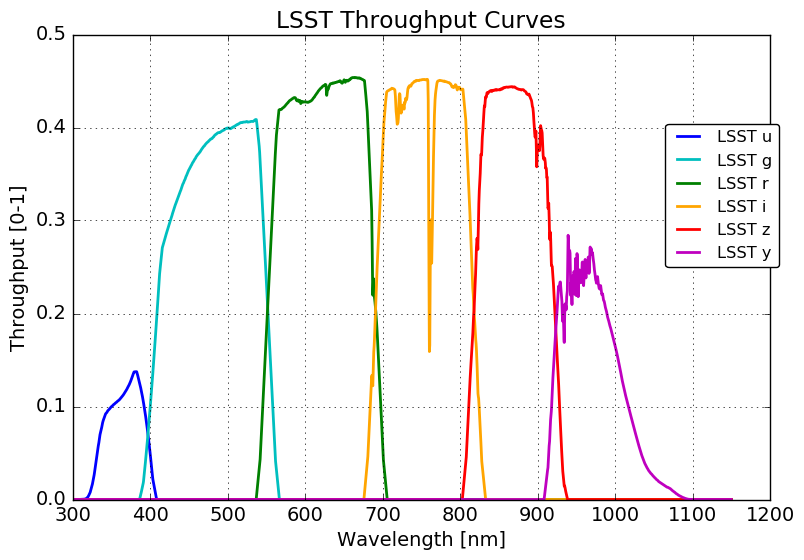

In [4]:
import lsst.sims.photUtils.Bandpass as Bandpass

lsst={}
x_func={}
s_x={}
dem_x={}
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
lsst_effl={'u':3654.9,'g':4800.3,'r':6222.0,'i':7540.6,'z':8682.1,'y':9916.6}
filtercolors = {'u':'b', 'g':'c', 'r':'g', 'i':'orange', 'z':'r', 'y':'m'}

for f in filterlist:
    lsst[f] = Bandpass()
    lsst[f].readThroughput('total_'+f+'.dat')

    trans_file=np.loadtxt('total_'+f+'.dat')
    lambda_filter=trans_file[:,0]*10     #in AA
    s_x[f]=trans_file[:,1]
    x_func[f]=interpolate.interp1d(lambda_filter,s_x[f])
    dem_x[f]=integrate.simps(x_func[f](lambda_filter)*1.0/lambda_filter,lambda_filter) 

    plt.plot(lsst[f].wavelen, lsst[f].sb, color=filtercolors[f], lw=2, label='LSST %s' % (f))

plt.xlabel('Wavelength [nm]')
plt.ylabel('Throughput [0-1]')
plt.title('LSST Throughput Curves')
plt.legend(loc=(0.85, 0.5), fancybox=True, fontsize='smaller')
plt.grid(True)
plt.savefig(os.path.join('LSSTfilters.png'), format='png')
plt.show()

## 1.2 K-corrections

We use [Dessart et al. 2013](http://esoads.eso.org/abs/2013MNRAS.433.1745D) models to measure K-corrections between bands

In [5]:
class Kcorrection(object):
    def __init__(self):
        self.array = np.empty((len(filterlist),len(filterlist),len(z_sim)))
        self.interpolate ={}
    
    def __getitem__(self,(f1,f2,z)):
        return self.array[filterlist.index(f1),filterlist.index(f2),z]

    def __setitem__(self,(f1,f2,z),value):
        self.array[filterlist.index(f1),filterlist.index(f2),z]=value
    
    def interpol(self,f1,f2):
        if f1+f2 not in self.interpolate:
            self.interpolate[f1+f2]=interpolate.interp1d(z_sim,self[f1,f2,:])  
        return self.interpolate[f1+f2]

In [6]:
#take Dessart' model 50 days after explosion
ascii=pd.read_table('m15mlt3/m15_du_sch_mlt3_FeC_mix0p4_18.fl',delim_whitespace=True,header=None)
lambda_model=ascii[0].values
flux_model=ascii[1].values

F_spec_model_0=interpolate.interp1d(lambda_model,flux_model)

Kcor=Kcorrection()
m_lsst_za={}
m_lsst_0={}
            
for i,zs in enumerate(z_sim):
    lambda_model_obs=lambda_model*(1+zs)
    flux_model_obs=flux_model/(1+zs)
    F_spec_model_z=interpolate.interp1d(lambda_model_obs,flux_model_obs)
    
    for f in filterlist:
        #comparison of F_spec_model_z and F_spec_model_0
        n_lsst_za=integrate.simps(F_spec_model_z(lambda_filter)*x_func[f](lambda_filter)*lambda_filter,lambda_filter)   
        m_lsst_za[f]=-2.5*(np.log10(n_lsst_za/dem_x[f]))-48.60+2.5*(np.log10(c_AA))
        #Comparison of F_spec_model_z(SDSS) and F_spec_model_0(CSP)
        n_lsst_0=integrate.simps(F_spec_model_0(lambda_filter)*x_func[f](lambda_filter)*lambda_filter,lambda_filter)   
        m_lsst_0[f]=-2.5*(np.log10(n_lsst_0/dem_x[f]))-48.60+2.5*(np.log10(c_AA))

    for j,f1 in enumerate(filterlist):
        for k,f2 in enumerate(filterlist):
            Kcor[f1,f2,i]=m_lsst_za[f1]-m_lsst_0[f2]

## 1.3 Here we construct a K-correction term from all bands to r-band

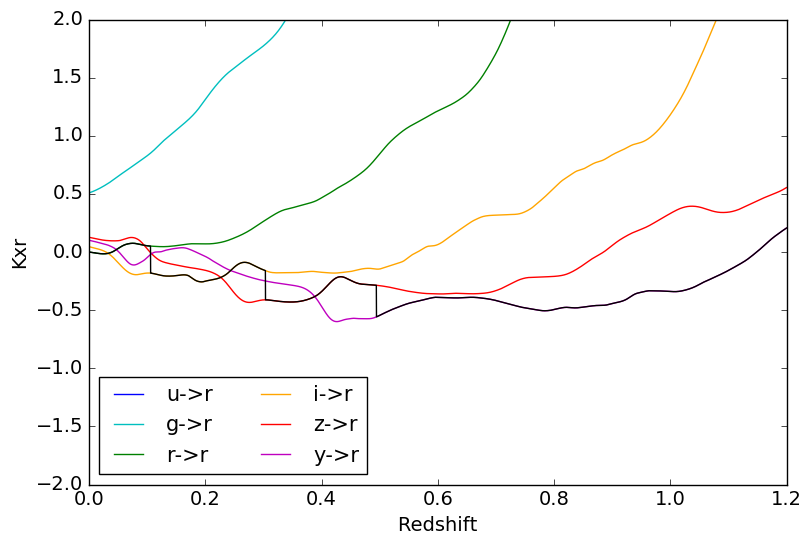

In [7]:
Kxr=np.zeros(len(z_sim))
for i,zs in enumerate(z_sim):
    #select the closest filter to r at a certain redshift
    lambda_eff=lsst_effl['r']*(1+zs)    
    ind_X = np.where(np.array(lsst_effl.values()) == find_nearest(lsst_effl.values(),lambda_eff) )[0][0]    
    Kxr[i]=Kcor[lsst_effl.keys()[ind_X],'r',i]

Kxr_func=interpolate.interp1d(z_sim,Kxr)

for j,f1 in enumerate(filterlist):
    plt.plot(z_sim,Kcor.interpol(f1,'r')(z_sim),filtercolors[f1])
plt.plot(z_sim,Kxr_func(z_sim),'black')
plt.xlabel('Redshift')
plt.ylabel('Kxr')
plt.ylim(-2,2)
plt.legend(('u->r','g->r','r->r','i->r','z->r','y->r'),loc=3,markerscale=0.5,prop={'size':15},ncol=2) 
plt.show()

#Final Kcorrections fron x to r in Kx_r and Kxr_func
# r->r if zs <= 0.105:
# i->r if zs > 0.105 and zs <= 0.303:
# z->r if zs > 0.303 and zs <= 0.494:
# y->r if zs > 0.494:

# 2. Calculating SNIa rate

The rate of SNe Ia per unit time per unit comoving volume (RII) is given by the star formation rate (SFR) per unit time per unit comoving volume convolved with the number of stars crearted that will explode as SNe Ia (which we will estimate assuming a [Salpeter et al. (1955)](http://adsabs.harvard.edu/abs/1955ApJ...121..161S) IMF.

## 2.1 Calculating the fraction of stars that explode as SN Ia

In [8]:
KII = 1.0

## 2.2 Calculating SFR

As an example, we will use 3 different SFR evolutions with redshift: [Cole et al. (2001)](http://adsabs.harvard.edu/abs/2001MNRAS.326..255C), [Horiuchi et al. (2011)](http://adsabs.harvard.edu/abs/2011ApJ...738..154H), and [Madau et al. (2014)](http://adsabs.harvard.edu/abs/2014ARA%26A..52..415M)

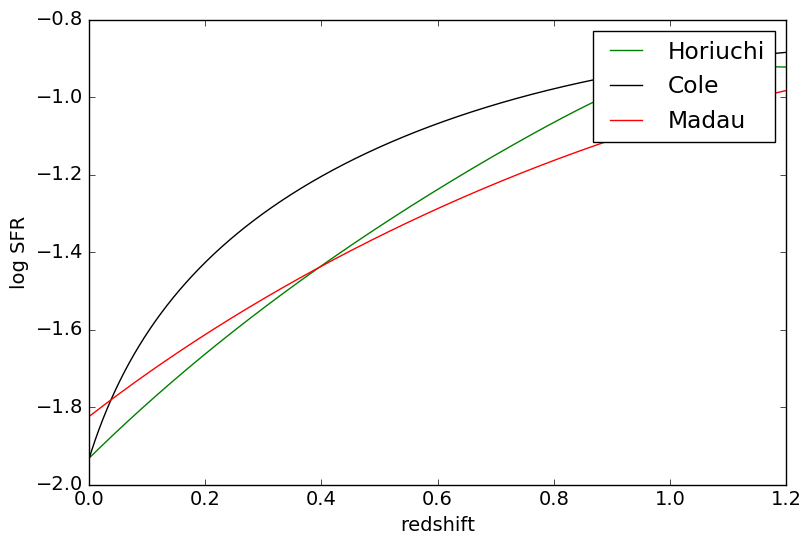

In [9]:
SFR_Horiuchi_vect=vectorize(SFR_Horiuchi)
SFR_Cole_vect=vectorize(SFR_Cole)
SFR_Madau_vect=vectorize(SFR_Madau)

plt.plot(z_sim,np.log10(SFR_Horiuchi_vect(z_sim)),'g',z_sim,np.log10(SFR_Cole_vect(z_sim)),'k',z_sim,np.log10(SFR_Madau_vect(z_sim)),'r')
plt.legend(('Horiuchi','Cole','Madau'))
plt.xlabel('redshift')
plt.ylabel('log SFR')
plt.show()

# 3. Example with SN Ia 1994D

## 3.1 At which redshift SN 1994D would not be detected with LSST?
We will first take SN Ia 1994D as a reference and assume that all SNe Ia are like 1994D. We simulate its r-band light curve at different redshifts and see that at z=0.39 it would be below the LSST detections limit


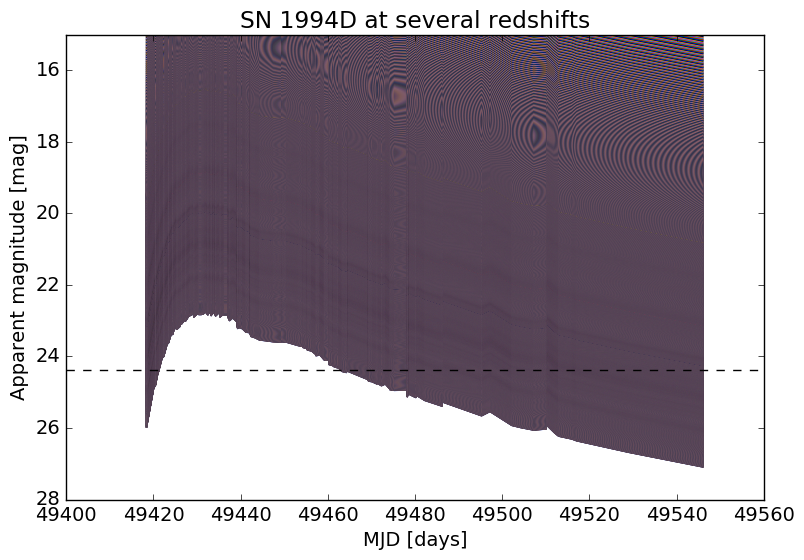

(array([121]),)


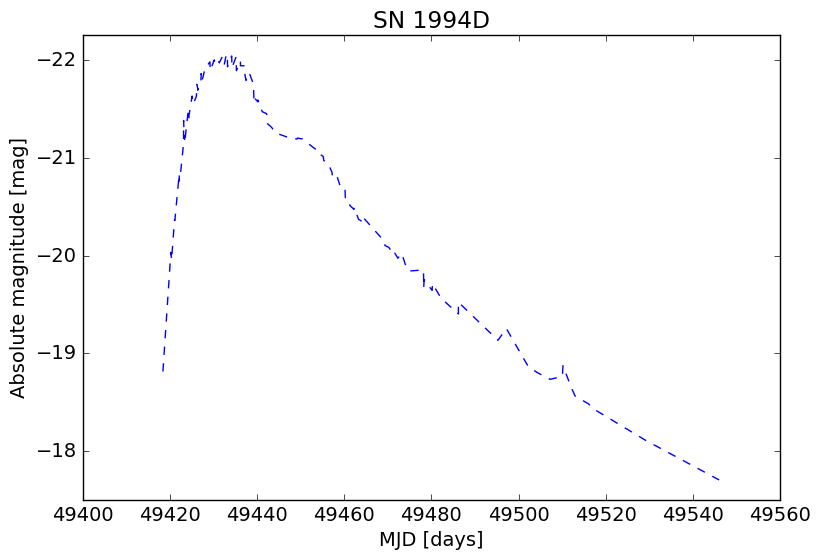

In [10]:
JD_explosion=2453382.78
JD_ref=2453000
z_cmb=4183./c_light
err_z_cmb=150./c_light

SN_photo=pd.read_table('SNLS3year_JRK07_1994D.dat',delim_whitespace=True, header=0)

SN_epoch=SN_photo['MJD'][SN_photo['FLT'] == 'R'].values
mag_r=SN_photo['MAG'][SN_photo['FLT'] == 'R'].values
dmag_r=SN_photo['MAGERR'][SN_photo['FLT'] == 'R'].values

M_SN_r=mag_r-5*np.log10(d_lum_distri(z_cmb))-25
dM_SN_r=np.sqrt(dmag_r**2+(np.array(err_z_cmb)*(5*(1+np.array(z_cmb))*1.0/(np.array(z_cmb)*(1+np.array(z_cmb)*1.0/2)*np.log10(10))))**2)

m_sn=np.zeros(shape=(len(SN_epoch),len(z_sim)))
for t,snep in enumerate(SN_epoch):
    for z,zs in enumerate(z_sim):
        m_sn[t,z]=M_SN_r[t]+d_mod_distri(zs)+Kxr_func(zs)
for z,zs in enumerate(z_sim):
    plt.plot(SN_epoch,m_sn[:,z]) 
    if min(m_sn[:,z]) > mag_lim['r']:
        print('Not visible from z='+str(zs))
        break
plt.ylim(28,15)
plt.axhline(mag_lim['r'], color='k', linestyle='--')
plt.xlabel('MJD [days]')
plt.ylabel('Apparent magnitude [mag]')
plt.title('SN 1994D at several redshifts')
plt.show()

print np.where(np.max(M_SN_r) == M_SN_r)

plt.plot(SN_epoch,M_SN_r, linestyle='--') 
plt.ylim(np.max(M_SN_r)+0.2,np.min(M_SN_r)-0.2)
plt.title('SN 1994D')
plt.ylabel('Absolute magnitude [mag]')
plt.xlabel('MJD [days]')
plt.show()


## 3.2 How many SNe Ia (SN 1994D-like) would the LSST discover in 1 year?

First, we compare our $m(t,z)$ with $m_{lim}$ of the LSST camera to obtain $\Delta_{t}(z)$,  the probability of detecting (the peak of) a SN at a given redshift 

In [11]:
t_min=[0]*len(z_sim)
t_max=[0]*len(z_sim)
t_max_2=[0]*len(z_sim)
delta_t_redshift=[0]*len(z_sim) #delta t corrected by redshift
epoch_model_z=[0]*len(SN_epoch)

for i,zs in enumerate(z_sim):
    epoch_model_z=SN_epoch*(1+zs)  #1+z factor for time dilation
    if min(m_sn[:,i][:])<mag_lim['r']:
        t_min[i]=epoch_model_z[min(np.where(m_sn[:,i]<=mag_lim['r'])[0])]
        o=set(np.where(epoch_model_z>=t_min[i])[0])   #index of the last t>t_min
        p=set(np.where(m_sn[:,i]<=mag_lim['r'])[0])        #index at which we see the SN
        q=(list(o-p))                                 #all the indeces where we see the peak
        if q==[]:
            t_max[i]=epoch_model_z[max(np.where(m_sn[:,i]<=mag_lim['r'])[0])]
            delta_t_redshift[i]=t_max[i]-t_min[i]
        else:
            t_max[i]=epoch_model_z[min(q)]
            t_max_2[i]=epoch_model_z[max(q)]
            delta_t_redshift[i]=(t_max[i]-t_min[i])+(max(epoch_model_z)-t_max_2[i])#le SBO+ rest of curve

Now we estimate the number of detected SNe Ia per unit of redshift, $dN/dz$. From Equations 2 and 5 of Forster et al. (2006)

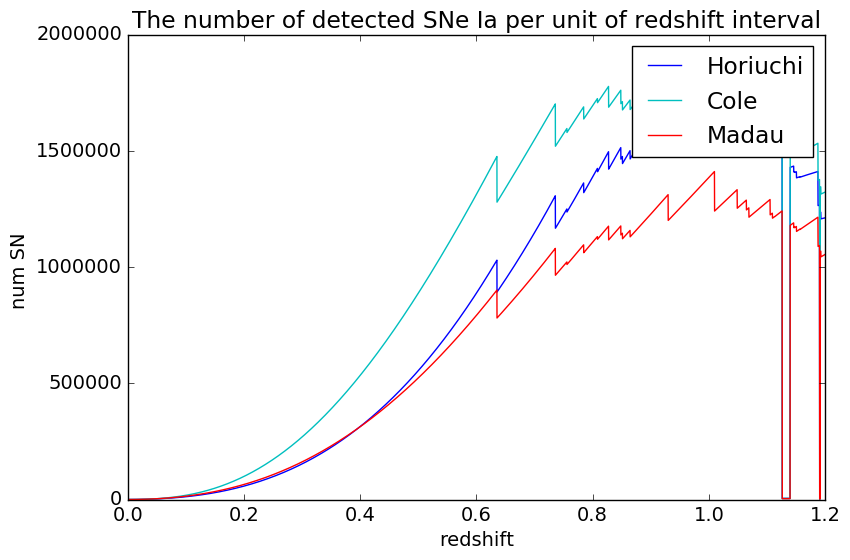

Num. SNe Horiuchi: 4826541791
Num. SNe Cole:     6183001242
Num. SNe Madau:     4054924188


In [12]:
dV_dz_dW=np.zeros(len(z_sim))

#############
survey_length=1.0   #in years
#############

dn_dz_Horiuchi=[0]*len(z_sim)   
dn_dz_Cole=[0]*len(z_sim)      
dn_dz_Madau=[0]*len(z_sim)      

for i,zs in enumerate(z_sim):
    dV_dz_dW[i]=(pow(r_com_distri(zs),2)*d_h*e_z_distri(zs))                 #dV(z) is the volume per unit redshift being surveyed

    #total observing time multiplied by the probability of detecting a SN
    dn_dz_Horiuchi[i]=SNR_Horiuchi(zs)/(1.+zs)*dV_dz_dW[i]*delta_omega*((delta_t_redshift[i])/365.25)*survey_length #In yr (SNR in yr)     #dn/dz is the SN per unit of redshift, comovil volume, solid angle and fied of view
    dn_dz_Cole[i]=SNR_Cole(zs)/(1+zs)*dV_dz_dW[i]*delta_omega*((delta_t_redshift[i])/365.25)*survey_length #In yr (SNR in yr)          #dn/dz is the SN per unit of redshift, comovil volume, solid anfle and fied of view
    dn_dz_Madau[i]=SNR_Madau(zs)/(1+zs)*dV_dz_dW[i]*delta_omega*((delta_t_redshift[i])/365.25)*survey_length #In yr (SNR in yr)        #dn/dz is the SN per unit of redshift, comovil volume, solid anfle and fied of view
                               
    
plt.plot(z_sim,dn_dz_Horiuchi,'b',z_sim,dn_dz_Cole,'c',z_sim,dn_dz_Madau,'r')
plt.title('The number of detected SNe Ia per unit of redshift interval')
plt.xlabel('redshift')
plt.ylabel('num SN ')
plt.legend(('Horiuchi','Cole','Madau'))
plt.show()

# We integrate for all the redshift to have the number of SN 
print('Num. SNe Horiuchi: '+str(int(np.sum(dn_dz_Horiuchi))))
for i,zs in enumerate(z_sim):
    if dn_dz_Horiuchi[i] == 0.0:
        print('No SNe Ia from z='+str(zs))
        break
        
print('Num. SNe Cole:     '+str(int(np.sum(dn_dz_Cole))))
for i,zs in enumerate(z_sim):
    if dn_dz_Cole[i] == 0.0:
        print('No SNe Ia from z='+str(zs))
        break
        
print('Num. SNe Madau:     '+str(int(np.sum(dn_dz_Madau))))
for i,zs in enumerate(z_sim):
    if dn_dz_Madau[i] == 0.0:
        print('No SNe Ia from z='+str(zs))
        break


# 5. Example with a CSP-like simulated sample of SNe Ia

Finally, we will use a a sample of 10,000 SNe, generate using equation 12 of Strolger et al. 2004. We will put each at redshifts rangin from 0.01 to 1.2.

In [13]:
survey_length=1.0
num_SN = 10

m_SN       = np.zeros((num_SN, len(z_sim), len(M_SN_r)))
delta_t_SN = np.zeros((num_SN, len(z_sim), len(M_SN_r)))

delta_M15 = np.random.normal(loc=1.1, scale=0.35, size=num_SN)
delta_m15 = 0.7 + 0.2*np.random.random(size=num_SN*0.2)
delta_m15 = np.append(delta_m15, 0.9 + 0.4*np.random.random(size=num_SN*0.6))
delta_m15 = np.append(delta_m15, 1.7 + 0.2*np.random.random(size=num_SN*0.2))
color_correction = 0.3*np.random.random(size=num_SN)

for i in range(num_SN):
    print delta_M15[i]
    if (delta_M15[i] > 0.7) and (delta_M15[i] < 1.7):
        delta_M_peak = 0.786*(delta_m15[i] - 1.1) + 0.633*(delta_m15[i] - 1.1)**2.
    elif (delta_M15[i] > 1.7) and (delta_M15[i] < 2.2):
        delta_M_peak = 1.35 + 0.786*(delta_m15[i] - 1.1) + 0.633*(delta_m15[i] - 1.1)**2.
    else:
        delta_M_peak = np.nan
    for z in range(len(z_sim)):
        k_correction = Kxr_func(z_sim[z])
        luminosity_distance = 5.*np.log10(d_lum_distri(z_sim[z])) + 25.
        SN_photo = M_SN_r + delta_M_peak + color_correction[i] + luminosity_distance + k_correction
        m_SN[i, z, :] = SN_photo

/Users/tinapeters/anaconda/envs/lsstmaf/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/tinapeters/anaconda/envs/lsstmaf/lib/python2.7/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/tinapeters/anaconda/envs/lsstmaf/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


1.11702299816
1.63571576733
1.07831613126
1.26851413749
0.513299229758
0.799284258637
2.00098880074
1.30675924991
1.24368986806
1.03945966164


nan nan


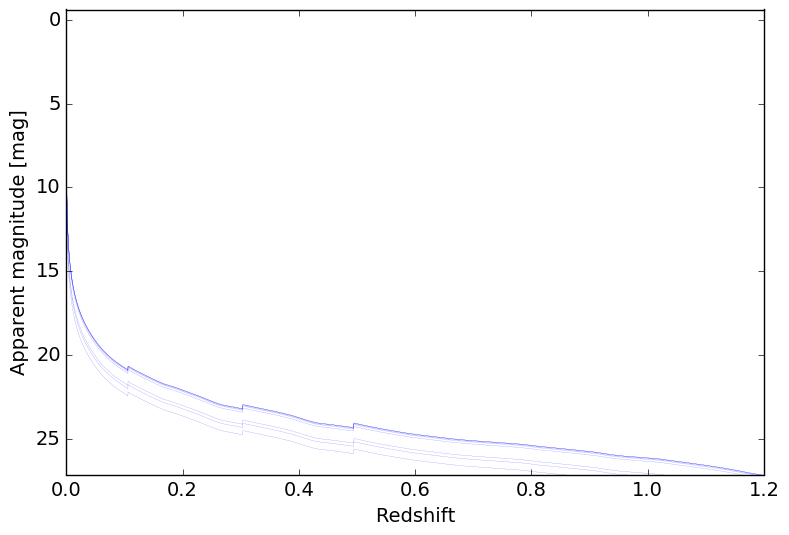

In [15]:
print np.min(m_SN), np.max(m_SN)
for i in range(num_SN):
    plt.plot(z_sim, m_SN[i,:,121].flatten(),alpha=0.9,linewidth=0.1,color='b')
plt.ylabel('Apparent magnitude [mag]')
plt.xlabel('Redshift')
plt.ylim(np.max(m_SN[i,:,115])+0.2,np.min(m_SN[i,:,115])-0.2)
plt.show()

Here we measure $\Delta_t(z)$, selecting different magnitude limit depending on the filter we use for observations.

In [16]:
for j in range((num_SN)):
    for i in range(len(z_sim)):
        if z_sim[i]<=0.3:           #V_swope would be converted to r_LSST                       
            if m_SN[j,i,121]<mag_lim['r']:
                delta_t_SN[j,i]=1.0
        elif (z_sim[i]>0.3) and (z_sim[i]<=0.57) :  #V_swope would be i_LSST
            if m_SN[j,i,121]<mag_lim['i']:
                delta_t_SN[j,i]=1.0
        elif (z_sim[i]>0.57) and (z_sim[i]<=0.78) : #V_swope would be z_LSST
            if m_SN[j,i,121]<mag_lim['z']:
                delta_t_SN[j,i]=1.0
        elif (z_sim[i]>0.78) :      #V_swope would be y_LSST
            if m_SN[j,i,121]<mag_lim['y']:
                delta_t_SN[j,i]=1.0

NOTE: this may be improved by carrying the distribution of delta_t_SN at each redshift, instead of simply measuring the average at each redshift

In [17]:
delta_t_SN_tot=np.zeros((len(z_sim)))
for i in range(len(z_sim)):
    delta_t_SN_tot[i]=np.sum(delta_t_SN[:,i])

delta_t_SN_tot=delta_t_SN_tot/num_SN

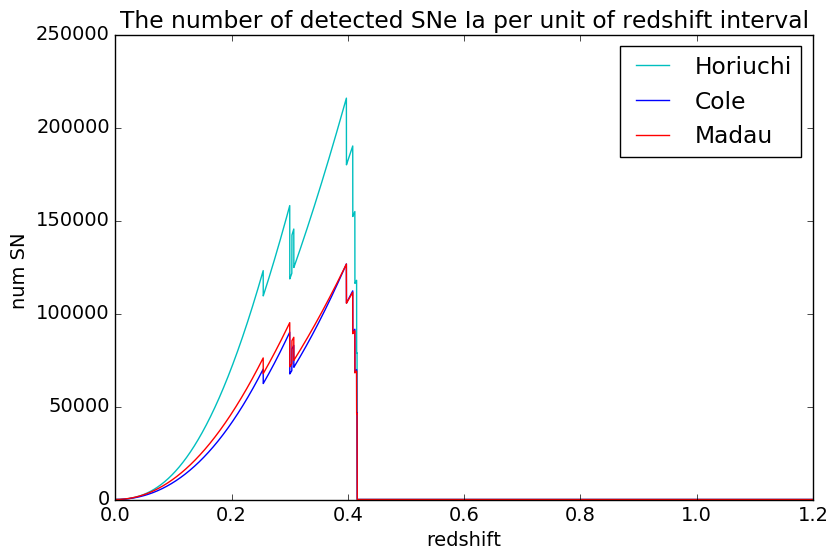

Num. SNe Horiuchi: 186940067
Num. SNe Cole:     321572877
Num. SNe Madau:     199007543
No SNe Ia from z=0.416152582304


In [18]:
dV_dz_dW=np.zeros(len(z_sim))

dn_dz_Horiuchi=np.zeros(len(z_sim)) 
dn_dz_Cole=np.zeros(len(z_sim))
dn_dz_Madau=np.zeros(len(z_sim))

for i in range(len(z_sim)):
    dV_dz_dW[i]=(pow(r_com_LCDM(z_sim[i]),2)*d_h*e_z_LCDM(z_sim[i]))    #dV(z) is the volume per unit redshift being surveyed

    dn_dz_Horiuchi[i]=SNR_Horiuchi(z_sim[i])/(1+z_sim[i])*dV_dz_dW[i]*delta_omega*(delta_t_SN_tot[i]/365.25)*survey_length #In yr (SNR in yr)  #dn/dz is the SN per unit of redshift, comovil volume, solid angle and fied of view
    dn_dz_Cole[i]    =SNR_Cole(z_sim[i])    /(1+z_sim[i])*dV_dz_dW[i]*delta_omega*(delta_t_SN_tot[i]/365.25)*survey_length #In yr (SNR in yr)  #dn/dz is the SN per unit of redshift, comovil volume, solid anfle and fied of view
    dn_dz_Madau[i]   =SNR_Madau(z_sim[i])   /(1+z_sim[i])*dV_dz_dW[i]*delta_omega*(delta_t_SN_tot[i]/365.25)*survey_length #In yr (SNR in yr)  #dn/dz is the SN per unit of redshift, comovil volume, solid anfle and fied of view                               

z_sim,dn_dz_Horiuchi,dn_dz_Cole,dn_dz_Madau = zip(*sorted(zip(z_sim,dn_dz_Horiuchi,dn_dz_Cole,dn_dz_Madau)))

plt.plot(z_sim,np.array(dn_dz_Cole),'c',z_sim,np.array(dn_dz_Horiuchi),'b',z_sim,np.array(dn_dz_Madau),'r')
plt.title('The number of detected SNe Ia per unit of redshift interval')
plt.xlabel('redshift')
plt.ylabel('num SN ')
plt.legend(('Horiuchi','Cole','Madau'))
plt.show()

# We integrate for all the redshift to have the number of SN 
print('Num. SNe Horiuchi: '+str(int(np.sum(dn_dz_Horiuchi))))
print('Num. SNe Cole:     '+str(int(np.sum(dn_dz_Cole))))    
print('Num. SNe Madau:     '+str(int(np.sum(dn_dz_Madau))))
z_tot_Madau=[]
for i,zs in enumerate(z_sim):
    if dn_dz_Madau[i] == 0.0:
        print('No SNe Ia from z='+str(zs))
        break

z_sim,dn_dz_Horiuchi,dn_dz_Cole,dn_dz_Madau = zip(*sorted(zip(z_sim,dn_dz_Horiuchi,dn_dz_Cole,dn_dz_Madau)))
z_tot_Madau=[]
for i,zs in enumerate(z_sim):
    for j in range((int(round(dn_dz_Madau[i],0)))):
        z_tot_Madau.append(zs)

In [19]:
data_save = np.column_stack((z_random, dn_dz_Horiuchi, dn_dz_Cole, dn_dz_Madau))
np.savetxt("SNeIa_rates.dat", data_save, fmt="%.9e", header = "number of detected SNeII per unit of redshift interval \n z_random \t dn_dz_Horiuchi dn_dz_Cole \t dn_dz_Madau")

ERROR: NameError: name 'z_random' is not defined [IPython.core.interactiveshell]


NameError: name 'z_random' is not defined

We have found the shape of the distribution, below one can create the final distribution by giving the total number of SNe II (with no selection effects) that LSST is supposed to found

In [ ]:
N_SNe_HD=input("Number of SNe for the Hubble diagram: ")
z_SNe_HD=np.random.choice(z_tot_Madau, N_SNe_HD, replace=True)

plt.hist(z_SNe_HD,color='blue',alpha=0.9,label='Single-visit')
plt.legend(loc=1,markerscale=0.5,prop={'size':12},ncol=2)
#plt.xlim(0,1.2)
plt.xlabel('redshift')
plt.ylabel('SN ')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.savefig('LSST_distribution.png')
plt.show()
